In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class Stoch_Binary_Reward_gen:
    def __init__(self):
        self.mean_vec=None
    def init_mean_vec(self,mean_vec):
        self.mean_vec=np.asarray(mean_vec)
    def get_reward(self,arm_id=None):
        if arm_id is None:
            sample=[np.random.binomial(n=1,p=p_hat,size=1)[0] for p_hat in self.mean_vec]
            return sample
        else:
            return np.random.binomial(n=1,p=self.mean_vec[arm_id],size=1)[0]

In [3]:
class Eps_Greedy:
    def __init__(self,eps,num_of_arms):
        self.eps=eps
        self.num_of_arms=num_of_arms
        self.mean_estimate=np.zeros(num_of_arms)
        self.count_for_arm=np.zeros(num_of_arms)
    def reset(self):
        self.mean_estimate=np.zeros(self.num_of_arms)
        self.count_for_arm=np.zeros(self.num_of_arms)
    def make_prediction(self):
        flag=np.random.binomial(n=1,p=self.eps)
        if flag==1:
            return np.random.randint(low=0,high=self.num_of_arms)
        else:
            return np.argmax(self.mean_estimate)
    def update_param(self,arm_id,reward):
        self.mean_estimate[arm_id]=(self.count_for_arm[arm_id]*self.mean_estimate[arm_id]+reward)/(self.count_for_arm[arm_id]+1)
        self.count_for_arm[arm_id]=self.count_for_arm[arm_id]+1

In [4]:
class UCB:
    def __init__(self,num_of_arms=10):
        self.num_of_arms=num_of_arms
        self.mean_estimate=np.zeros(num_of_arms)
        self.count_for_arm=np.zeros(num_of_arms)
        self.t=0 
    def reset(self):
        self.t=0
        self.mean_estimate=np.zeros(self.num_of_arms)
        self.count_for_arm=np.zeros(self.num_of_arms)
    def make_prediction(self):
        if self.t<self.num_of_arms:
            return self.t
        UCB_vec=np.asarray([self.mean_estimate[arm_id]-np.sqrt(2*np.log(self.t)/self.count_for_arm[arm_id]) for arm_id in range(self.num_of_arms)])
        return np.argmax(UCB_vec)
    def update_param(self,arm_id,reward):
        self.mean_estimate[arm_id]=(self.count_for_arm[arm_id]*self.mean_estimate[arm_id]+reward)/(self.count_for_arm[arm_id]+1)
        self.count_for_arm[arm_id]=self.count_for_arm[arm_id]+1
        self.t+=1

In [5]:
class Thompson_Sampling:
    def __init__(self,num_of_arms=10):
        self.num_of_arms=num_of_arms
        self.alpha_beta_mat=np.ones(shape=(num_of_arms,2))
    def reset(self):
        self.alpha_beta_mat=np.ones(shape=(self.num_of_arms,2))
    def make_prediction(self):
        Q_vec=np.asanyarray([np.random.beta(self.alpha_beta_mat[x][0],self.alpha_beta_mat[x][1]) for x in range(self.num_of_arms)])
        return np.argmax(Q_vec)
    def update_param(self,arm_id,reward):
        if reward==0:
            self.alpha_beta_mat[arm_id][1]+=1
        else:
            self.alpha_beta_mat[arm_id][0]+=1

In [6]:
class EXP3:
    def __init__(self,num_of_arms=10,eta=0.1):
        self.num_of_arms=num_of_arms
        self.eta=eta
        self.distrib=np.divide(np.ones(num_of_arms),num_of_arms)
        self.count_for_arms=np.zeros(num_of_arms)
    def reset(self):
        self.distrib=np.divide(np.ones(self.num_of_arms),self.num_of_arms)
        self.count_for_arms=np.zeros(self.num_of_arms)
    def make_prediction(self):
        return np.random.choice(list(range(self.num_of_arms)),p=self.distrib)
    def update_param(self,arm_id,reward):
        z_hat=np.zeros(self.num_of_arms)
        z_hat[arm_id]=reward/self.distrib[arm_id]
        exp_vec=np.exp(self.eta*z_hat)
        dup=self.distrib.copy()
        sum=np.inner(dup,exp_vec)
        for i in range(len(self.distrib)):
            self.distrib[i]=dup[i]*exp_vec[i]/sum
        self.count_for_arms[arm_id]+=1


In [7]:
Env=Stoch_Binary_Reward_gen()
mean_vec=np.linspace(start=0,stop=1,num=12)[1:11]
Env.init_mean_vec(mean_vec)

Eps_Greedy_one_instance=Eps_Greedy(eps=1,num_of_arms=10)
Eps_Greedy_instance=Eps_Greedy(eps=0.1,num_of_arms=10)
UCB_instance=UCB(num_of_arms=10)
Thompson_Sampling_instance=Thompson_Sampling(num_of_arms=10)
EXP3_instance=EXP3()



In [8]:
T=np.power(10,5)    # no of time steps
N=np.power(10,1)    # no sample trajectory

Eps_Greedy_one_instance.reset()
Eps_Greedy_instance.reset()
UCB_instance.reset()
Thompson_Sampling_instance.reset()
EXP3_instance.reset()

ALG_list=[Eps_Greedy_one_instance,Eps_Greedy_instance,UCB_instance,Thompson_Sampling_instance,EXP3_instance]
look_up=dict()
for x in ALG_list:
    look_up.update({x:np.zeros(shape=(2,T))})

In [9]:



for learner in ALG_list:
    learner.reset()

    
    
    regret_mat=np.zeros(shape=(N,T))

    for i in tqdm(range(N)): 

        # N Sample trajectories

        reward_acc_vec=np.zeros(10)
        reward_acc=0

        for t in range(T):

            arm_id=learner.make_prediction()
            reward_vec=Env.get_reward()
            reward_at_t=reward_vec[arm_id]

            reward_acc=reward_acc+reward_at_t
            reward_acc_vec=reward_acc_vec+reward_vec
            
            learner.update_param(arm_id=arm_id,reward=reward_at_t)
            regret_mat[i][t]=np.max(reward_acc_vec)-reward_acc  # !!!!!    This def of regret is used !!!

    mean_vec=np.average(regret_mat,axis=0)
    STD_vec=np.sqrt(np.var(regret_mat,axis=0))
    look_up[learner][0]=mean_vec
    look_up[learner][1]=STD_vec    

100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


In [10]:
def plot(dict):
    Names=["Uniform -Sampling","Eps_Greedy with eps=0.1","UCB","Thompson Sampling","EXP-3"]
    for x in range(5):
        Avg=list(look_up.values())[x][0]
        STD=list(look_up.values())[x][1]
        avg_line=Avg
        LCB=Avg-STD
        UCB=Avg+STD
        plt.title(Names[x])
        plt.plot(avg_line,'-b', label='mean')
        plt.plot(LCB,'-r',label="LCB")
        plt.plot(UCB,'-g',label="UCB")
        # fill the area with black color, opacity 0.15
        plt.fill_between(list(range(len(avg_line))), UCB,LCB, color="k", alpha=0.15)

        plt.xlabel("Time Instant")
        plt.ylabel("Cum Regret")
        plt.legend()
        plt.show()
        plt.clf()

    return

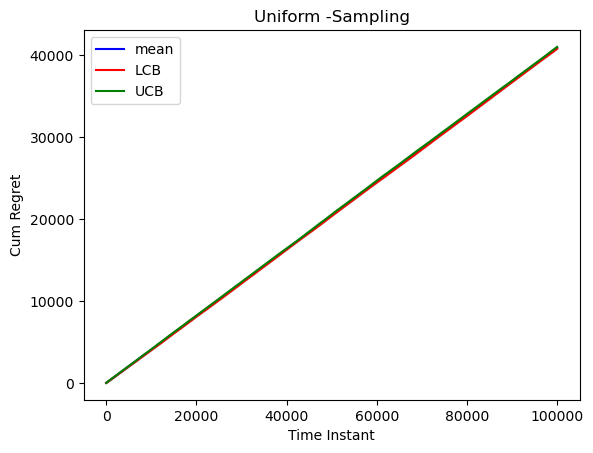

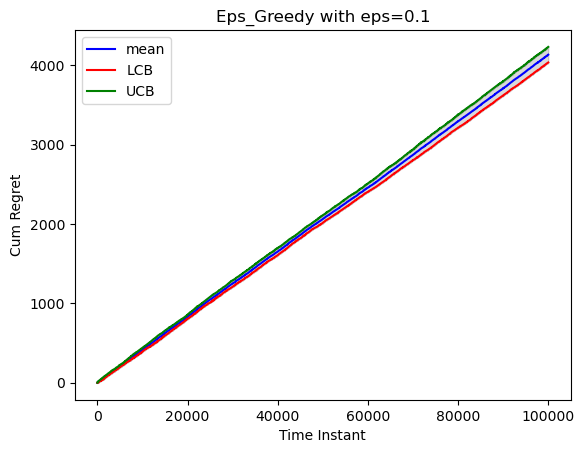

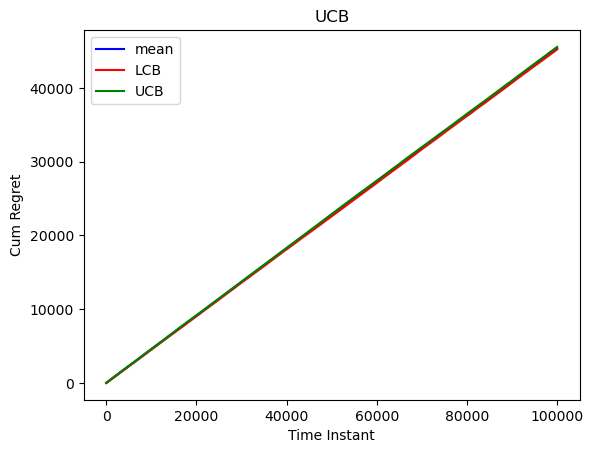

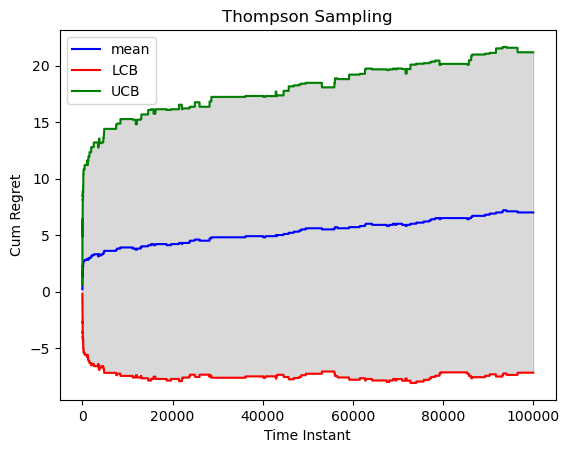

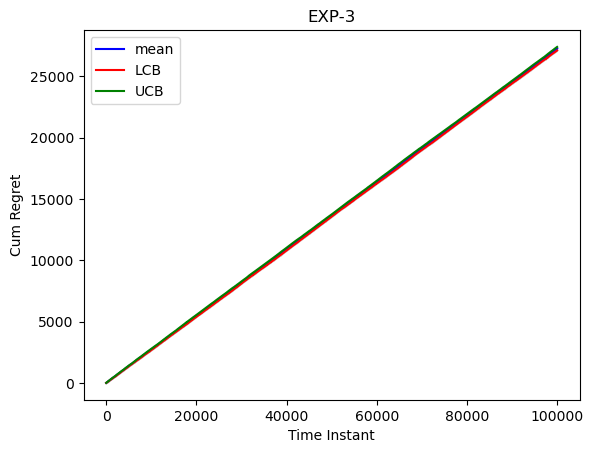

<Figure size 640x480 with 0 Axes>

In [11]:
plot(look_up)

In [12]:
# Alg - Test bench
# input : algorithm object 
# Works for Eps-Greedy , UCB
def Test_Bench(Eps_Greedy_instance):

    Eps_Greedy_instance.reset()
    
    for i in range(21):
        
        arm_id=Eps_Greedy_instance.make_prediction()
        reward=Env.get_reward(arm_id)
        Eps_Greedy_instance.update_param(arm_id=arm_id,reward=reward)

        if i%10==0:
            
            print("\nMean estimate")
            print(Eps_Greedy_instance.mean_estimate)
            print("\nCount ")
            print(Eps_Greedy_instance.count_for_arm.sum())

In [13]:
# TS-Test bench

Thompson_Sampling_instance.reset()
i=0
while i<20:
    arm_id=Thompson_Sampling_instance.make_prediction()
    print(Thompson_Sampling_instance.alpha_beta_mat[arm_id])
    reward=Env.get_reward(arm_id)
    Thompson_Sampling_instance.update_param(arm_id,reward)
    print(Thompson_Sampling_instance.alpha_beta_mat[arm_id])
    i+=1
    print("\n")



[1. 1.]
[2. 1.]


[1. 1.]
[2. 1.]


[1. 1.]
[2. 1.]


[2. 1.]
[3. 1.]


[1. 1.]
[1. 2.]


[2. 1.]
[3. 1.]


[3. 1.]
[4. 1.]


[2. 1.]
[2. 2.]


[1. 1.]
[2. 1.]


[4. 1.]
[5. 1.]


[1. 1.]
[1. 2.]


[1. 2.]
[2. 2.]


[2. 1.]
[2. 2.]


[5. 1.]
[6. 1.]


[1. 1.]
[1. 2.]


[6. 1.]
[7. 1.]


[3. 1.]
[4. 1.]


[7. 1.]
[8. 1.]


[8. 1.]
[9. 1.]


[4. 1.]
[5. 1.]




In [14]:
EXP3_instance.reset()
    
for i in range(21):
    
    arm_id=EXP3_instance.make_prediction()
    reward=Env.get_reward(arm_id)
    EXP3_instance.update_param(arm_id=arm_id,reward=reward)

    if i%10==0:
        
        print("Arm distrib")
        print(EXP3_instance.distrib)
        print("\nCount ")
        print(EXP3_instance.count_for_arms)

Arm distrib
[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.23196932
 0.08533674 0.08533674 0.08533674 0.08533674]

Count 
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Arm distrib
[0.04398996 0.04398996 0.04398996 0.04398996 0.23143435 0.19973916
 0.04398996 0.04398996 0.26089679 0.04398996]

Count 
[0. 1. 1. 0. 3. 4. 1. 0. 1. 0.]
Arm distrib
[0.02557336 0.02557336 0.02557336 0.02557336 0.13454331 0.11611745
 0.02557336 0.02557336 0.57032571 0.02557336]

Count 
[0. 2. 1. 1. 4. 5. 1. 0. 6. 1.]


In [15]:
# Test_Bench(UCB_instance)